# Introduction to Data Science
# Lecture 15 continued - Classification Competition
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/* 

We will use classification methods to study this [dataset on contraceptive methods used by Indonesian women](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice). This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

We will use k-nearest neighbor, decision tree, and support vector machines (SVM) methods in the [scikit-learn](http://scikit-learn.org/) library.

## The Data

We will explore a dataset about the use of contraception in Indonesia. The dataset has 1473 records and the following attributes:

1. Woman's age (numerical) 
+ Woman's education (categorical) 1=low, 2, 3, 4=high 
+ Husband's education (categorical) 1=low, 2, 3, 4=high 
+ Number of children ever born (numerical) 
+ Woman's religion (binary) 0=Non-Islam, 1=Islam 
+ Employed? (binary) 0=Yes, 1=No 
+ Husband's occupation (categorical) 1, 2, 3, 4 
+ Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
+ Media exposure (binary) 0=Good, 1=Not good 

along with the variable we are trying to predict: 

+ Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

### Hypothesis

Which features do you think have the most impact on the use of contraception?

**Your hypothesis:** TODO

### Preliminaries

We'll start with the usual imports:

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn import tree

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

from sklearn import svm

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

### Loading and exploring the dataset

In [2]:
contraception_df = pd.read_csv("cmc.csv")
contraception_df.head(10)

,Age,Education,Husband-Education,Children,Religion,Employed,Husband-Occupation,Standard-of-living,Media-exposure,Contraceptive-method-used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
5,19,4,4,0,1,1,3,3,0,1
6,38,2,3,6,1,1,3,2,0,1
7,21,3,3,1,1,0,3,2,0,1
8,27,2,3,3,1,1,3,4,0,1
9,45,1,1,8,1,1,2,2,1,1


In [3]:
contraception_df.describe()

,Age,Education,Husband-Education,Children,Religion,Employed,Husband-Occupation,Standard-of-living,Media-exposure,Contraceptive-method-used
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


Here are a couple of definitions that might come in handy:

In [4]:
cmethod = "Contraceptive-method-used"
labels =["None", "Long-Term", "Short-Term"]
features = ['Age', 'Education', 'Husband-Education', 'Children', 'Religion',
       'Employed', 'Husband-Occupation', 'Standard-of-living',
       'Media-exposure']
religion_children = ['Children', 'Religion',
       'Employed', 'Education']


Let's take a look at the data. How are the contraception methods distributed?

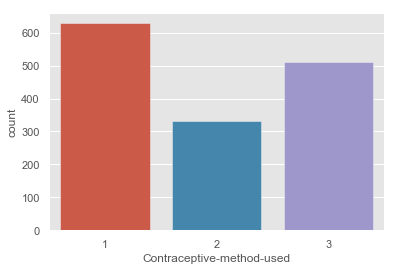

In [5]:
ax = sns.countplot(x=cmethod, data=contraception_df)

Let's look at the age distribution:

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


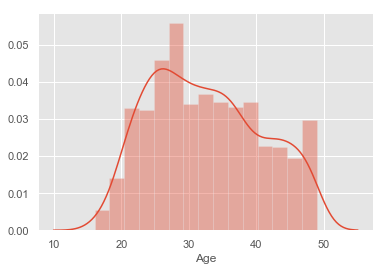

In [6]:
sns.distplot(contraception_df["Age"])

And facet age by contraceptive method:

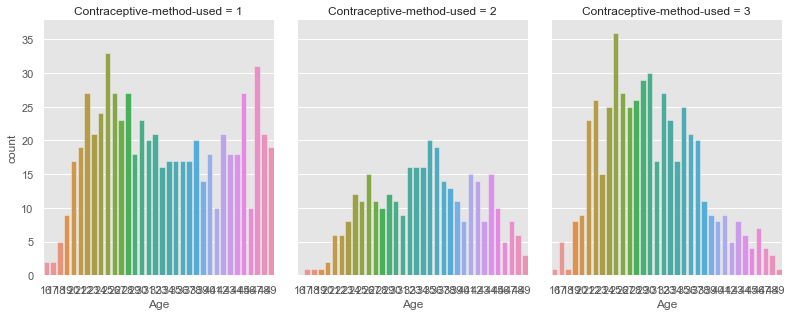

In [7]:
g = sns.catplot("Age", col=cmethod, col_wrap=4, 
                   data=contraception_df[contraception_df["Age"].notnull()],
                   kind="count", height=4.5, aspect=.8)

We see some patterns, but let's look instead at bar charts split up by contraceptive method.

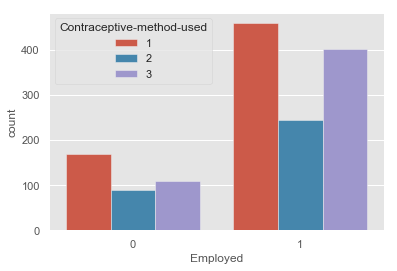

In [8]:
sns.countplot(x="Employed", hue=cmethod, data=contraception_df);

### Explore Other Variables
See whether you can find other variables that have a larger effect on the predicted classes. 

In [9]:
# your code here


## Feature Selection

Let's take a look at which features have potentially the most impact on our classification. SciPy comes with [a rich feature selection module](http://scikit-learn.org/stable/modules/feature_selection.html). We'll use univariate methods here:
+ [SelectPercentile](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) to have a look at P values, and 
+ [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) to pick features.

Here, we'll use the $\chi^2$ test, but there are other methods.

In [10]:
features = contraception_df.columns[:-1]
X = contraception_df[features].values
y = contraception_df["Contraceptive-method-used"].values

selector = SelectPercentile(chi2)
X_new = selector.fit_transform(X, y)
print(features)
print("P Values:", selector.pvalues_)

Index(['Age', 'Education', 'Husband-Education', 'Children', 'Religion',
       'Employed', 'Husband-Occupation', 'Standard-of-living',
       'Media-exposure'],
      dtype='object')
P Values: [1.54469599e-29 1.22480564e-10 8.72157331e-03 1.58696556e-10
 1.98956005e-01 5.22194355e-01 1.15289549e-04 1.01048659e-04
 4.48216856e-07]


In [11]:
selector = SelectKBest(chi2, k=3)
X_new = selector.fit_transform(X, y)
print(features)
selector.get_support()

Index(['Age', 'Education', 'Husband-Education', 'Children', 'Religion',
       'Employed', 'Husband-Occupation', 'Standard-of-living',
       'Media-exposure'],
      dtype='object')


array([ True,  True, False,  True, False, False, False, False, False])

In [12]:
best_features = ['Age', 'Education', 'Children']

### Helpful code for visualization and splitting the dataset

Here is some code for plotting decision trees. This uses pydotplus, if you haven't already, install it:

```
pip install pydotplus
```

You also need to install graphviz. This might be tricky on windows. You can also render the dot files using [this web renderer](http://www.webgraphviz.com/).

In [13]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree,my_features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=my_features, 
                                 class_names=labels,  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

Here is some code that splits the data into training and test sets for cross-validation and selects features.

In [14]:
def splitData(features):
    contraception_labels = contraception_df["Contraceptive-method-used"].values
    contraception_predictors =  contraception_df[features].values

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(contraception_predictors, contraception_labels, 
                                                    random_state=1, test_size=0.2)
    return XTrain, XTest, yTrain, yTest

## Classification competition 

We'll now compare various classification methods on this dataset. 

### K-Nearest Neighbors

Experiment with different numbers of neighbors, $k$, and different features.

Usse the `splitData()` function to divide your data into training and test sets. 

Refer to the [scikit learn documentation](http://scikit-learn.org/stable/modules/neighbors.html) and the  [lecture on k nearest neighbors](https://github.com/datascience-course/2019-datascience-lectures/blob/master/13-Classification1/13b-Classification1.ipynb).

In [15]:
# your code here

XTrain, XTest, yTrain, yTest = splitData(best_features)


### Decision Trees

Classify the data using decision trees. Experiment with different depths, minimum samples to split on, and minimum samples to remain after the split, as well as with a combination of different features.

Usse the `splitData()` function to divide your data into training and test sets. 

Refer to the [scikit learn documentation](http://scikit-learn.org/stable/modules/tree.html) and the  [lecture on decision trees](https://github.com/datascience-course/2019-datascience-lectures/blob/master/14-Classification2/14-Classification2-Decision-Trees.ipynb).

You can use the `renderTree()` function to render the tree, if you have the proper libraries installed.

In [16]:
# your code here


### Support Vector Machines (SVM )

Experiment with different kernels, C values and different features. Use cross validation to find a good C value. Print accuracy and the confusion matrix.

Refer to the [scikit learn documentation](http://scikit-learn.org/stable/modules/svm.html)  and the [lecture on SVM](https://github.com/datascience-course/2019-datascience-lectures/blob/master/15-Classification3/15a-Classification3-SVM.ipynb).

In [17]:
# your code here


### Reflections and discussion 
1. Which classification method had the highest accuracy for this dataset? 
+ Which classification method was easiest to use? 
+ Which classification method is most interpretable? 
+ Which would you use for this application? 

**Your answers:** TODO